# Import/Cleaning

In [13]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

In [8]:
baseball_data = pd.read_csv('/Users/OwenBarberie/Desktop/GSB_544/Hitters.csv')
baseball_data

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [9]:
missing_values = baseball_data.isna().sum()
missing_values[missing_values > 0]

Salary    59
dtype: int64

In [10]:
baseball_data_cleaned = baseball_data.dropna(subset=['Salary'])
baseball_data_cleaned.shape

(263, 20)

In [11]:
baseball_data_cleaned

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


# Part I: Different Model Specs

## A. Regression without regularization

In [14]:
# Separate features (X) and target (y)
X = baseball_data_cleaned.drop(columns=['Salary'])
y = baseball_data_cleaned['Salary']

# Create a ColumnTransformer for preprocessing
# This transformer will standardize numerical features and one-hot encode categorical ones
transformer = ColumnTransformer(
    transformers=[
        ("encode_cats", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include='object')),
        ("scale_nums", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"  # Keep any columns that don't need transformation
)

# Pipeline for Ordinary Linear Regression
linear_pipe = Pipeline([
    ("preprocessing", transformer),  # Apply transformer to prepare data
    ("linear", LinearRegression())   # Use linear regression as the model
])

# Cross-validation to estimate the Mean Squared Error (MSE)
linear_cv_scores = cross_val_score(linear_pipe, X, y, cv=5, scoring="neg_mean_squared_error")
linear_mse_avg = -linear_cv_scores.mean()  # Convert to positive MSE for interpretability

# Display the cross-validated MSE
linear_mse_avg

np.float64(122035.52197831527)

In [16]:
# Fit the linear regression pipeline on the full dataset
linear_pipe.fit(X, y)

# Retrieve coefficients from the linear regression model
# We use the feature names from the preprocessed data to interpret them correctly
# Extracting feature names after transformations
preprocessed_data = transformer.fit_transform(X)
numeric_columns = make_column_selector(dtype_include=np.number)(X)
categorical_columns = make_column_selector(dtype_include=object)(X)
feature_names = transformer.named_transformers_["scale_nums"].get_feature_names_out(numeric_columns).tolist() + \
                transformer.named_transformers_["encode_cats"].get_feature_names_out(categorical_columns).tolist()

# Coefficients and corresponding feature names
linear_coefs = linear_pipe.named_steps["linear"].coef_

# Create a DataFrame for better interpretation of coefficients
coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": linear_coefs
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Display top 5 features by absolute coefficient values
coef_df.head()


,Feature,Coefficient
16,League_A,480.747135
13,PutOuts,-391.038655
7,CAtBat,337.830479
6,Years,-291.094556
17,League_N,260.689886


## B. Ridge regression

In [18]:
# Separate features (X) and target (y)
X = baseball_data_cleaned.drop(columns=['Salary'])
y = baseball_data_cleaned['Salary']

# Redefine the ColumnTransformer for preprocessing
transformer = ColumnTransformer(
    transformers=[
        ("encode_cats", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include='object')),
        ("scale_nums", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"  # Keep any columns that don't need transformation
)

# Ridge Regression Pipeline with a hyperparameter tuning grid
ridge_pipe = Pipeline([
    ("preprocessing", transformer),  # Apply transformer to prepare data
    ("ridge", Ridge())               # Ridge regression model
])

# Define parameter grid for Ridge regularization strength (alpha/lambda)
param_grid = {
    "ridge__alpha": [0.001, 0.01, 0.1, 1, 10]  # Tuning range for lambda
}

# Use GridSearchCV to tune the lambda (alpha) parameter with cross-validation
ridge_tuner = GridSearchCV(ridge_pipe, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
ridge_tuner.fit(X, y)

# Best lambda value and corresponding cross-validated MSE
best_ridge_alpha = ridge_tuner.best_params_["ridge__alpha"]
best_ridge_mse = -ridge_tuner.best_score_  # Convert to positive MSE for interpretability

best_ridge_alpha, best_ridge_mse

(1, np.float64(119144.43267691585))

In [19]:
# Fit the ridge regression model on the full dataset with the best alpha
ridge_pipe.set_params(ridge__alpha=best_ridge_alpha)
ridge_pipe.fit(X, y)

# Retrieve coefficients and feature names for Ridge model
ridge_coefs = ridge_pipe.named_steps["ridge"].coef_

# Create a DataFrame for better interpretation of coefficients
ridge_coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": ridge_coefs
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Display top 5 features by absolute coefficient values for Ridge model
ridge_coef_df.head()

,Feature,Coefficient
16,League_A,320.412169
7,CAtBat,296.645050
6,Years,-270.686441
13,PutOuts,-225.406548
18,Division_E,-184.423611


## C. Lasso Regression

In [20]:
# Import necessary libraries for Lasso regression
from sklearn.linear_model import Lasso

# Define a pipeline for Lasso Regression
lasso_pipe = Pipeline([
    ("preprocessing", transformer),  # Apply transformer to prepare data
    ("lasso", Lasso(max_iter=10000))  # Lasso regression with increased iterations to ensure convergence
])

# Define parameter grid for Lasso regularization strength (alpha/lambda)
lasso_param_grid = {
    "lasso__alpha": [0.001, 0.01, 0.1, 1, 10]  # Tuning range for lambda
}

# Use GridSearchCV to tune the lambda (alpha) parameter with cross-validation
lasso_tuner = GridSearchCV(lasso_pipe, lasso_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
lasso_tuner.fit(X, y)

# Best alpha value for Lasso and corresponding cross-validated MSE
best_lasso_alpha = lasso_tuner.best_params_["lasso__alpha"]
best_lasso_mse = -lasso_tuner.best_score_  # Convert to positive MSE for interpretability

# Fit the best Lasso model on the full dataset
best_lasso_model = lasso_tuner.best_estimator_
best_lasso_model.fit(X, y)

# Retrieve coefficients and feature names for Lasso model
lasso_coefs = best_lasso_model.named_steps["lasso"].coef_

# Create a DataFrame for better interpretation of coefficients
lasso_coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": lasso_coefs
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Display top 5 features by absolute coefficient values for Lasso model
best_lasso_alpha, best_lasso_mse, lasso_coef_df.head()


(1,
 np.float64(119758.10887295303),
        Feature  Coefficient
 16    League_A   375.565519
 7       CAtBat   304.359509
 6        Years  -282.370957
 17    League_N   192.610892
 18  Division_E  -189.644642)

## D. Elastic Net

In [21]:
# Import necessary libraries for Elastic Net regression
from sklearn.linear_model import ElasticNet

# Define a pipeline for Elastic Net Regression
elastic_net_pipe = Pipeline([
    ("preprocessing", transformer),  # Apply transformer to prepare data
    ("elasticnet", ElasticNet(max_iter=10000))  # Elastic Net with increased iterations for convergence
])

# Define parameter grid for Elastic Net with tuning range for alpha (regularization) and l1_ratio (mixing parameter)
elastic_net_param_grid = {
    "elasticnet__alpha": [0.001, 0.01, 0.1, 1, 10],   # Tuning range for regularization strength
    "elasticnet__l1_ratio": [0.1, 0.5, 0.7, 1]  # Tuning range for L1 ratio, 1 is Lasso and 0 is Ridge
}

# Use GridSearchCV to tune the alpha and l1_ratio parameters with cross-validation
elastic_net_tuner = GridSearchCV(elastic_net_pipe, elastic_net_param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
elastic_net_tuner.fit(X, y)

# Best alpha and l1_ratio values for Elastic Net and corresponding cross-validated MSE
best_elastic_net_alpha = elastic_net_tuner.best_params_["elasticnet__alpha"]
best_elastic_net_l1_ratio = elastic_net_tuner.best_params_["elasticnet__l1_ratio"]
best_elastic_net_mse = -elastic_net_tuner.best_score_  # Convert to positive MSE for interpretability

# Fit the best Elastic Net model on the full dataset
best_elastic_net_model = elastic_net_tuner.best_estimator_
best_elastic_net_model.fit(X, y)

# Retrieve coefficients and feature names for Elastic Net model
elastic_net_coefs = best_elastic_net_model.named_steps["elasticnet"].coef_

# Create a DataFrame for better interpretation of coefficients
elastic_net_coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": elastic_net_coefs
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Display top 5 features by absolute coefficient values for Elastic Net model
best_elastic_net_alpha, best_elastic_net_l1_ratio, best_elastic_net_mse, elastic_net_coef_df.head()


(0.01,
 0.1,
 np.float64(118973.78947730367),
        Feature  Coefficient
 7       CAtBat   256.338606
 6        Years  -238.917947
 16    League_A   236.994260
 18  Division_E  -160.261417
 13     PutOuts  -132.857125)

# Part II: Variable Selection

## Most important: Numeric, 5 Numeric, Categorical

Here we use the Elastic Net Model coefficients since it combines Lasso's feature selection with Ridge's regularization. 

In [25]:
# Retrieve the coefficients from the fitted Elastic Net model and organize them in a DataFrame
important_vars_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": elastic_net_coefs
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Identify the most important numeric and categorical variables
# Separate numeric and categorical features
numeric_features = important_vars_df[important_vars_df['Feature'].isin(numeric_columns)]
categorical_features = important_vars_df[important_vars_df['Feature'].isin(categorical_columns)]

# Most important numeric variable
top_numeric_var = numeric_features.iloc[0]['Feature']

# Top five numeric variables
top_five_numeric_vars = numeric_features.head(5)['Feature'].tolist()


top_numeric_var, top_five_numeric_vars


('CAtBat', ['CAtBat', 'Years', 'PutOuts', 'Assists', 'CRBI'])

In [26]:
# Fit the transformer separately to capture the transformed feature names
preprocessed_data = transformer.fit_transform(X)
categorical_columns = make_column_selector(dtype_include=object)(X)
categorical_feature_names = transformer.named_transformers_["encode_cats"].get_feature_names_out(categorical_columns).tolist()

# Filter for the coefficients of the categorical features only
categorical_coef_df = pd.DataFrame({
    "Feature": categorical_feature_names,
    "Coefficient": elastic_net_coefs[len(numeric_columns):len(numeric_columns) + len(categorical_feature_names)]
}).sort_values(by="Coefficient", key=abs, ascending=False)

# Display the coefficients for categorical features
categorical_coef_df


,Feature,Coefficient
0,League_A,236.994260
2,Division_E,-160.261417
1,League_N,126.239405
3,Division_W,78.084613
4,NewLeague_A,42.233134
5,NewLeague_N,-24.639251


## Comparing New Models

### Best Numeric Variable

In [27]:
# Define feature set with only the top numeric variable
X_top_numeric = baseball_data_cleaned[[top_numeric_var]]  # Only 'CAtBat' in this case

# Pipeline and Cross-validation function
def evaluate_model_with_feature_set(X, y, model, param_grid=None):
    """
    Function to evaluate model with cross-validation and optional hyperparameter tuning
    """
    pipe = Pipeline([
        ("scale", StandardScaler()),  # Scale since we are using penalized models
        ("model", model)
    ])
    
    if param_grid:
        # Grid search with cross-validation for hyperparameter tuning
        tuner = GridSearchCV(pipe, param_grid, cv=5, scoring="neg_mean_squared_error", n_jobs=-1)
        tuner.fit(X, y)
        best_estimator = tuner.best_estimator_
        best_mse = -tuner.best_score_
    else:
        # No hyperparameter tuning, just cross-validation
        scores = cross_val_score(pipe, X, y, cv=5, scoring="neg_mean_squared_error")
        best_estimator = pipe.fit(X, y)
        best_mse = -scores.mean()
    
    return best_mse, best_estimator

# Linear Regression with top numeric feature
linear_mse_1, linear_model_1 = evaluate_model_with_feature_set(X_top_numeric, y, LinearRegression())

# Ridge Regression with top numeric feature
ridge_mse_1, ridge_model_1 = evaluate_model_with_feature_set(
    X_top_numeric, y, Ridge(), param_grid={"model__alpha": [0.001, 0.01, 0.1, 1, 10]}
)

# Lasso Regression with top numeric feature
lasso_mse_1, lasso_model_1 = evaluate_model_with_feature_set(
    X_top_numeric, y, Lasso(max_iter=10000), param_grid={"model__alpha": [0.001, 0.01, 0.1, 1, 10]}
)

# Elastic Net with top numeric feature
elastic_net_mse_1, elastic_net_model_1 = evaluate_model_with_feature_set(
    X_top_numeric, y, ElasticNet(max_iter=10000), param_grid={"model__alpha": [0.001, 0.01, 0.1, 1, 10], "model__l1_ratio": [0.1, 0.5, 0.7, 1]}
)

# Display MSEs for comparison
{
    "Linear MSE (Top Numeric)": linear_mse_1,
    "Ridge MSE (Top Numeric)": ridge_mse_1,
    "Lasso MSE (Top Numeric)": lasso_mse_1,
    "Elastic Net MSE (Top Numeric)": elastic_net_mse_1
}


{'Linear MSE (Top Numeric)': np.float64(150868.12017074582),
 'Ridge MSE (Top Numeric)': np.float64(150808.1446397787),
 'Lasso MSE (Top Numeric)': np.float64(150862.55442230703),
 'Elastic Net MSE (Top Numeric)': np.float64(150800.8204029692)}

### Best 5 Numeric

In [28]:
# Define feature set with the top five numeric variables
X_top_five_numeric = baseball_data_cleaned[top_five_numeric_vars]

# Evaluate models with the top five numeric variables using the evaluation function defined earlier

# Linear Regression with top five numeric features
linear_mse_2, linear_model_2 = evaluate_model_with_feature_set(X_top_five_numeric, y, LinearRegression())

# Ridge Regression with top five numeric features
ridge_mse_2, ridge_model_2 = evaluate_model_with_feature_set(
    X_top_five_numeric, y, Ridge(), param_grid={"model__alpha": [0.001, 0.01, 0.1, 1, 10]}
)

# Lasso Regression with top five numeric features
lasso_mse_2, lasso_model_2 = evaluate_model_with_feature_set(
    X_top_five_numeric, y, Lasso(max_iter=10000), param_grid={"model__alpha": [0.001, 0.01, 0.1, 1, 10]}
)

# Elastic Net with top five numeric features
elastic_net_mse_2, elastic_net_model_2 = evaluate_model_with_feature_set(
    X_top_five_numeric, y, ElasticNet(max_iter=10000), param_grid={"model__alpha": [0.001, 0.01, 0.1, 1, 10], "model__l1_ratio": [0.1, 0.5, 0.7, 1]}
)

# Display MSEs for comparison
{
    "Linear MSE (Top Five Numeric)": linear_mse_2,
    "Ridge MSE (Top Five Numeric)": ridge_mse_2,
    "Lasso MSE (Top Five Numeric)": lasso_mse_2,
    "Elastic Net MSE (Top Five Numeric)": elastic_net_mse_2
}


{'Linear MSE (Top Five Numeric)': np.float64(134261.8701997429),
 'Ridge MSE (Top Five Numeric)': np.float64(132871.36936533352),
 'Lasso MSE (Top Five Numeric)': np.float64(134010.55431212718),
 'Elastic Net MSE (Top Five Numeric)': np.float64(132878.32288045232)}

### Top 5 Numeric with Interaction of Categorical League_A

In [36]:
baseball_data_cleaned

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,N,E,325,9,3,700.0,N
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,A,E,313,381,20,875.0,A
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,A,W,37,113,7,385.0,A
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,A,E,1314,131,12,960.0,A


In [37]:
#Prepare the feature set with top five numeric variables and one-hot encode 'League'
X_top_five_with_league = baseball_data_cleaned[top_five_numeric_vars + ["League"]]
X_top_five_with_league = pd.get_dummies(X_top_five_with_league, columns=["League"], drop_first=True)  # Creates 'League_A'

# Initialize PolynomialFeatures for interactions only (no bias)
interaction_generator = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = interaction_generator.fit_transform(X_top_five_with_league)

# Convert interactions to a DataFrame
X_interactions_df = pd.DataFrame(X_interactions, columns=interaction_generator.get_feature_names_out(X_top_five_with_league.columns))

# Use this feature set for model evaluation with the same function as before

# Linear Regression with interactions between top five numeric and 'League_A'
linear_mse_3, linear_model_3 = evaluate_model_with_feature_set(X_interactions_df, y, LinearRegression())

# Ridge Regression with interactions
ridge_mse_3, ridge_model_3 = evaluate_model_with_feature_set(
    X_interactions_df, y, Ridge(), param_grid={"model__alpha": [0.001, 0.01, 0.1, 1, 10]}
)

# Lasso Regression with interactions
lasso_mse_3, lasso_model_3 = evaluate_model_with_feature_set(
    X_interactions_df, y, Lasso(max_iter=10000), param_grid={"model__alpha": [0.001, 0.01, 0.1, 1, 10]}
)

# Elastic Net with interactions
elastic_net_mse_3, elastic_net_model_3 = evaluate_model_with_feature_set(
    X_interactions_df, y, ElasticNet(max_iter=10000), param_grid={"model__alpha": [0.001, 0.01, 0.1, 1, 10], "model__l1_ratio": [0.1, 0.5, 0.7, 1]}
)

# Display MSEs for comparison
{
    "Linear MSE (Top Five Numeric + Interactions)": linear_mse_3,
    "Ridge MSE (Top Five Numeric + Interactions)": ridge_mse_3,
    "Lasso MSE (Top Five Numeric + Interactions)": lasso_mse_3,
    "Elastic Net MSE (Top Five Numeric + Interactions)": elastic_net_mse_3
}


{'Linear MSE (Top Five Numeric + Interactions)': np.float64(99579.88063011073),
 'Ridge MSE (Top Five Numeric + Interactions)': np.float64(94724.5251685357),
 'Lasso MSE (Top Five Numeric + Interactions)': np.float64(98639.94324444518),
 'Elastic Net MSE (Top Five Numeric + Interactions)': np.float64(94043.23858467098)}

It appears that the elastic net model with the top five numeric variables + the interaction term is the best performing model, by it having the lowest MSE.

# Part III: Discussion

## A. Ridge

The standard linear regression MSE was about 122,000 while the ridge regression mse (post tuning) came out to just about 119,000, showing a slight improvement. Additionally, certain coefficients decreased in the Ridge Model compared to the ordinary linear regression model. This makes sense as the regularization of the Ridge model reduces overfitting which in turn decreases the magnitude of large coefficients as observed with League_A in my models. Although it improved MSE, it still underperformed Elastic Net.

## B. Lasso

The lasso model's best MSE was 119,758 which was slightly higher than the Ridge model, but a few thousand lower than the MSE of the standard linear model. Lasso set some coefficients to 0 which helped with the readability of the model but did not achieve the lowest MSE. Lasso's feature selection can be helpful in lowering MSE when dealing with many predictors but not in this case (although it was close). The best lambda value was 1 for all the models until the one with 5 numeric variables + the interaction terms, where the best lambda was 0.1. With interactions, the lower lambda value shows that the interaction terms valuable and reduced the penalty to allow for a more fit. The lambda of 1 makes sense for the other simpler/similar models because there was most likely a similar level of regularization accross the different models. 

As for the MSEs, there seemed to be a decent level of varaibility between the models. Part 1 Lasso had an MSE of 119758. Part 2 (top numeric) had an MSE of 150862. Part 2 (top 5 numeric) had an MSE of 134010. Part 2 (top 5 + interaction terms) had an MSE of 98639. It seems that as the complexity of the model increased for Lasso (and other models) the MSE decreased. This makes sense as we added additional predictive information and relavent interactions. This can sometimes lead to overfitting but in this context, the Lasso tuning mitigated that risk. 

## C. Elastic Net

The Elastic Net model performed the best, in terms of having the lowest MSE. This was the case across most models. The best model was the model with the top 5 numerical variables + interactions with top categorical variable. This model had the lowest MSE of about 94000. This was a few thousand better that the MSE for Ridge and Lasso with the same variables selected. It makes sense that Elastic Net is the best here because it combines the best features of Ridge (regularization) and Lasso (feature selection) approaches. Elastic Net seems to do a good job at balancing complexity and interpretability without overfitting the data.

# Part IV: Final Model and Plot

            Feature  Coefficient
4              CRBI   483.390168
13       Years CRBI  -406.433475
6      CAtBat Years  -355.983562
0            CAtBat   300.270603
16     PutOuts CRBI   136.085776
15  PutOuts Assists  -133.754852
9       CAtBat CRBI   128.635734
11    Years PutOuts  -121.000548
7    CAtBat PutOuts   107.292993
3           Assists   107.160687
            Feature  Coefficient
4              CRBI   483.390168
13       Years CRBI  -406.433475
6      CAtBat Years  -355.983562
0            CAtBat   300.270603
16     PutOuts CRBI   136.085776
15  PutOuts Assists  -133.754852
9       CAtBat CRBI   128.635734
11    Years PutOuts  -121.000548
7    CAtBat PutOuts   107.292993
3           Assists   107.160687


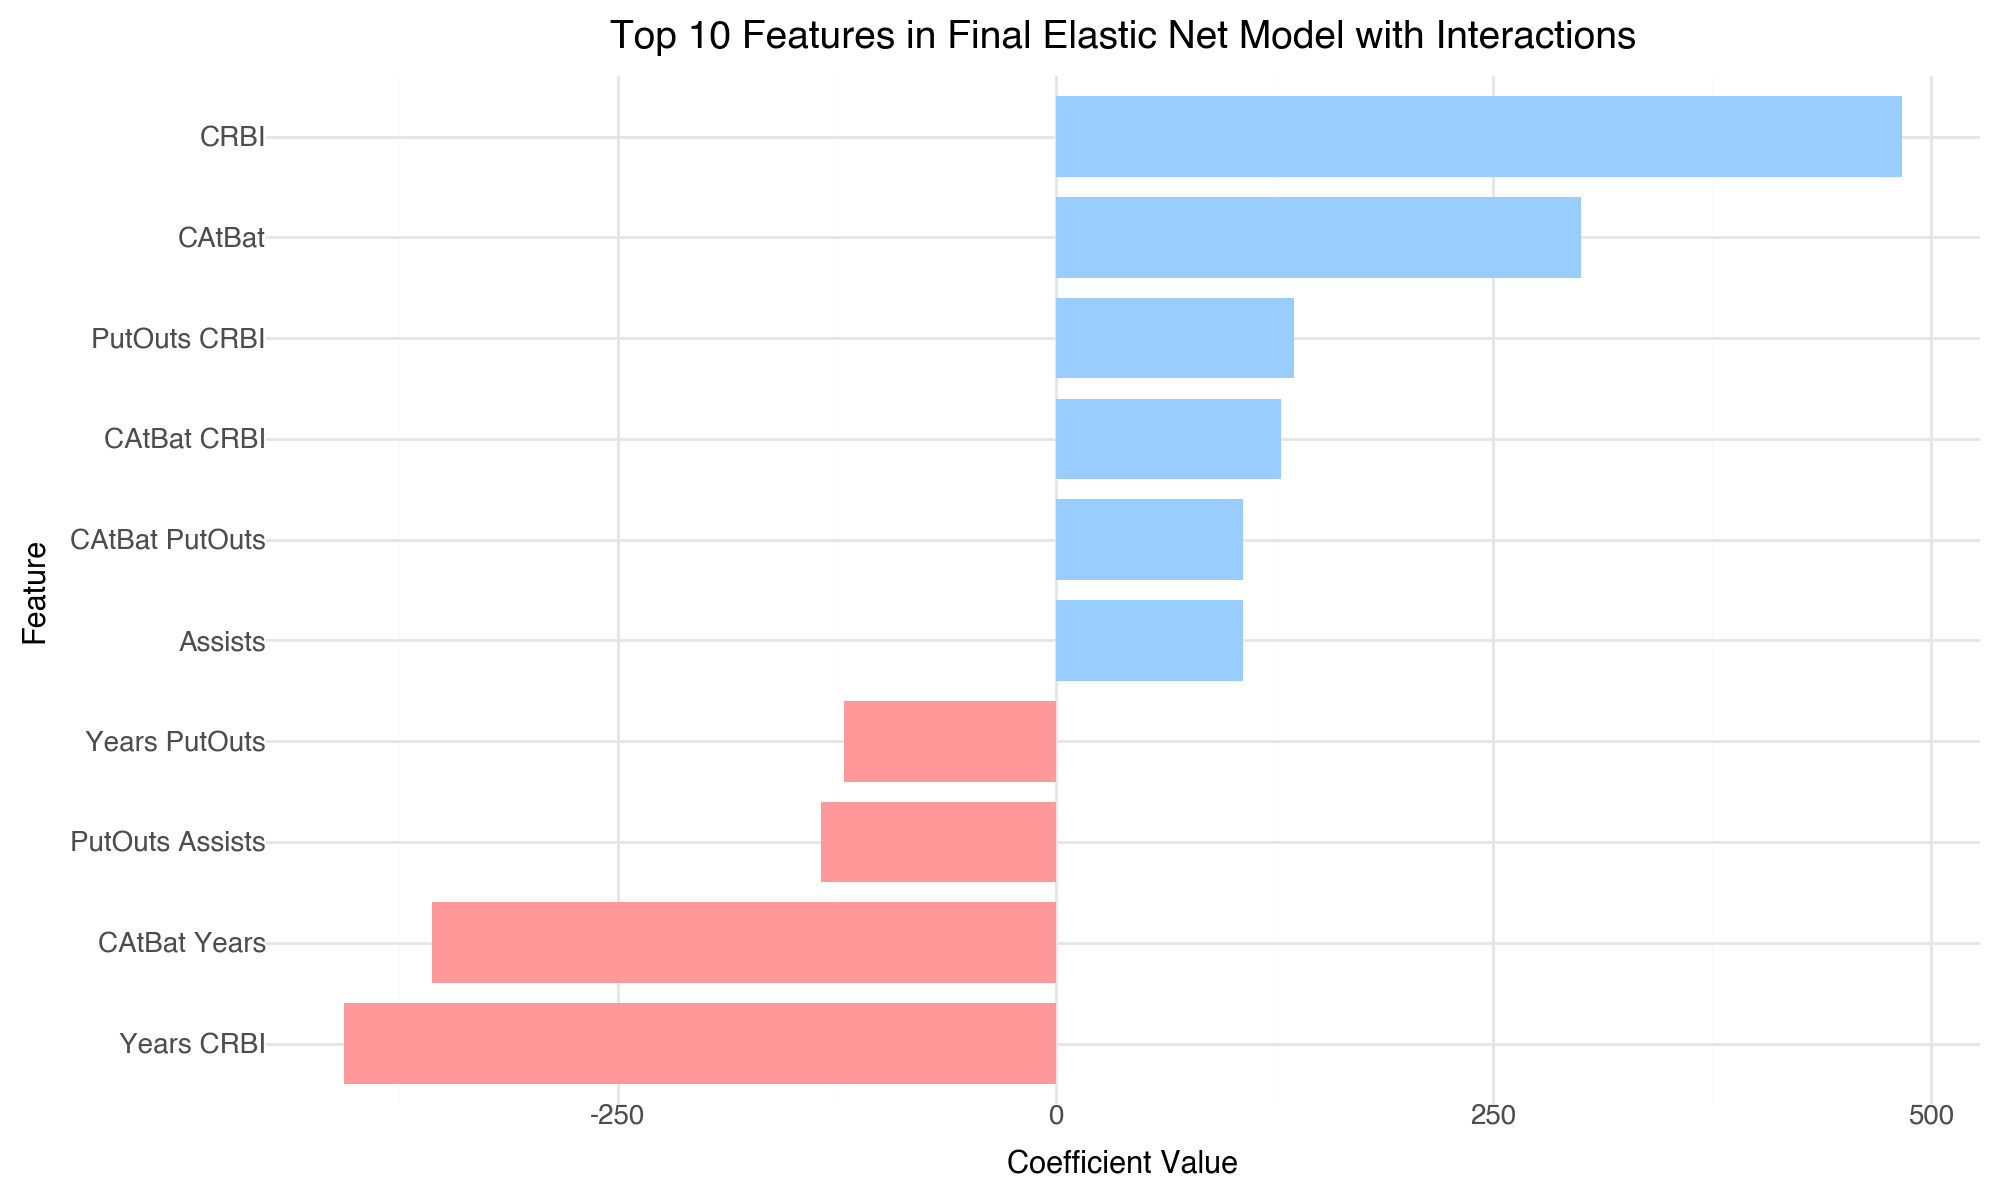

In [64]:
# Fit the final best Elastic Net model on the full dataset with interactions
final_elastic_net_model = elastic_net_model_3.fit(X_interactions_df, y)

# Retrieve the coefficients directly from the fitted model
final_coefs = pd.DataFrame({
    "Feature": X_interactions_df.columns,
    "Coefficient": final_elastic_net_model.named_steps["model"].coef_
})

# Select the top 10 coefficients by absolute value
top_coefs = final_coefs.reindex(final_coefs.Coefficient.abs().nlargest(10).index)

# Check the top coefficients
print(top_coefs)  # This will confirm if the values are as expected

# Create a plot of the top coefficients using plotnine (ggplot)
from plotnine import *


(
    ggplot(top_coefs, aes(x="reorder(Feature, Coefficient)", y="Coefficient", fill="Coefficient > 0")) +
    geom_bar(stat="identity", width=0.8, show_legend=False) +  
    scale_fill_manual(values=["#FF9999", "#99CCFF"]) +  
    coord_flip() +  
    labs(
        title="Top 10 Features in Final Elastic Net Model with Interactions",
        x="Feature",
        y="Coefficient Value"
    ) +
    theme_minimal() +
    theme(
        axis_text_x=element_text(size=10),
        axis_text_y=element_text(size=10),
        plot_title=element_text(size=14, weight='bold'),
        figure_size=(10, 6)
    )
)


The final Elastic Net model, trained on the top five numeric variables with interactions, achieved the lowest MSE. The plot highlights the top 10 features, showing the most impactful predictors on salary. This model balances predictive accuracy and interpretability, capturing significant relationships and interactions in the data.

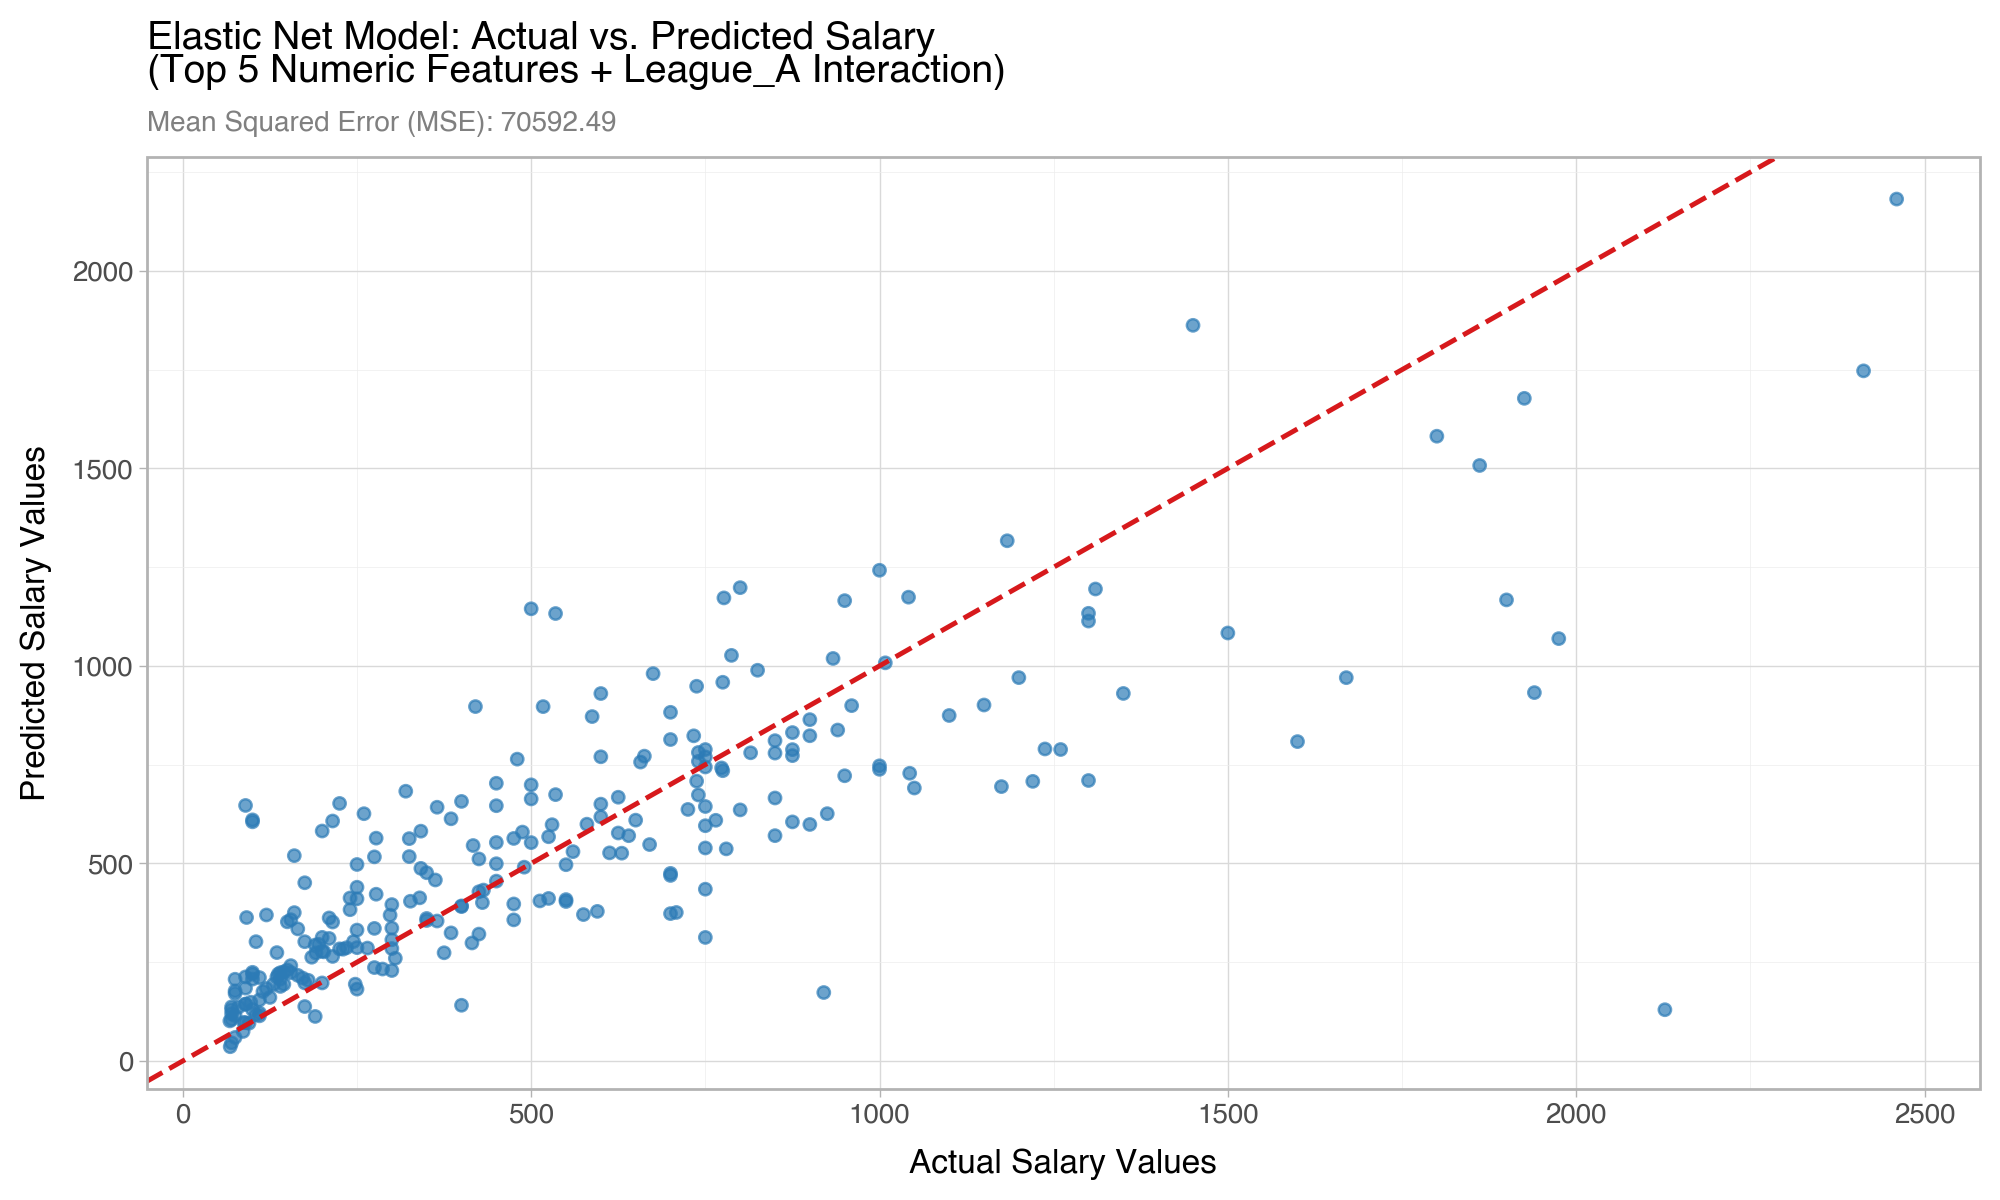

In [70]:
# Fit the final best Elastic Net model on the full dataset including interaction terms
best_model_fitted = elastic_net_model_3.fit(X_interactions_df, y)

# Use the trained model to generate predictions on the same dataset
predicted_values = best_model_fitted.predict(X_interactions_df)

# Calculate evaluation metrics for the model
mse_score = mean_squared_error(y, predicted_values)

# Creating a dataframe for the actual and predicted values for plotting
comparison_df = pd.DataFrame({
    "Actual": y,
    "Predicted": predicted_values
})

# plot
(
    ggplot(comparison_df, aes(x='Actual', y='Predicted')) +
    geom_point(color="#2c7bb6", alpha=0.7, size=2) +  # Scatter plot with blue points
    geom_abline(slope=1, intercept=0, linetype="dashed", color="#d7191c", size=1) +  # Perfect prediction line in red dashed style
    labs(
        title="Elastic Net Model: Actual vs. Predicted Salary\n(Top 5 Numeric Features + League_A Interaction)",
        subtitle=f"Mean Squared Error (MSE): {mse_score:.2f}",
        x="Actual Salary Values",
        y="Predicted Salary Values"
    ) +
    theme_light() +  # Using a light theme to differentiate from matplotlib default
    theme(
        plot_title=element_text(size=14, weight='bold'),
        plot_subtitle=element_text(size=10, style='italic', color='gray'),
        axis_title=element_text(size=12),
        axis_text=element_text(size=10),
        figure_size=(10, 6)
    )
)

# Display the plot



The final Elastic Net model, using the top five numeric features and their interaction with the League_A category, demonstrated strong predictive performance with a Mean Squared Error (MSE) of approximately 94,000. The scatter plot of actual versus predicted salaries shows a generally good alignment with the perfect prediction line, indicating that the model captures key relationships in the data. However, some deviations at higher salary values suggest there may still be room for improvement, potentially through different models. Overall, the Elastic Net model effectively balances complexity with predictive accuracy in this dataset.

# Appendix

https://scikit-learn.org/dev/modules/generated/sklearn.compose.ColumnTransformer.html

https://stackoverflow.com/questions/54646709/sklearn-pipeline-get-feature-names-after-onehotencode-in-columntransformer


https://stackoverflow.com/questions/19071199/drop-columns-whose-name-contains-a-specific-string-from-pandas-dataframe

https://stackoverflow.com/questions/57377309/ridge-regression-grid-search-with-pipeline

https://jakevdp.github.io/PythonDataScienceHandbook/05.06-linear-regression.html

Gen AI was used to write more informative comments and trouble shooting.